<a href="https://colab.research.google.com/github/AkshayKulla/End-to-End-ML/blob/main/End_to_End_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#Importing the required Libraries
# Import Libraries and modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from textblob import TextBlob
from IPython.display import Image
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import gensim

import warnings
warnings.filterwarnings('ignore')


In [16]:
#Attatching the database
# Load the clustering dataset
clustering_dataset_path = '/content/drive/MyDrive/DATASETS/Zomato Restaurant names and Metadata.csv'
clustering_df = pd.read_csv(clustering_dataset_path)

# Load the sentiment analysis dataset
sentiment_dataset_path = '/content/drive/MyDrive/DATASETS/Zomato Restaurant reviews.csv'
sentiment_df = pd.read_csv(sentiment_dataset_path)

## ***1. Know Your Data***

In [17]:
# Display the first few rows of the DataFrame
display(clustering_df.head())
print('\n\n\n')
display(sentiment_df.head())

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [18]:
# Calculate summary statistics for numerical features
summary_stats = clustering_df.describe()
print("Summary Statistics:")
display(summary_stats)
print('\n\n\n')
summary_stats = sentiment_df.describe()
print("Summary Statistics:")
display(summary_stats)

Summary Statistics:


,Name,Links,Cost,Collections,Cuisines,Timings
count,105,105,105,51,105,104
unique,105,105,29,42,92,77
top,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,500,Food Hygiene Rated Restaurants in Hyderabad,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,4,6






Summary Statistics:


,Pictures
count,10000.000000
mean,0.748600
std,2.570381
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,64.000000


In [19]:
# Check the data types of each feature
data_types1 = clustering_df.dtypes
print("\nData Types:")
display(data_types1)
print('\n\n\n')
data_types2 = sentiment_df.dtypes
print("\nData Types:")
display(data_types2)



Data Types:


Name           object
Links          object
Cost           object
Collections    object
Cuisines       object
Timings        object
dtype: object






Data Types:


Restaurant    object
Reviewer      object
Review        object
Rating        object
Metadata      object
Time          object
Pictures       int64
dtype: object

In [20]:
# Identify and handle any missing values in the dataset
missing_values1 = clustering_df.isnull().sum()
print("\nMissing Values:")
display(missing_values1)
print('\n\n\n')
missing_values2 = sentiment_df.isnull().sum()
print("\nMissing Values:")
display(missing_values2)


Missing Values:


Name            0
Links           0
Cost            0
Collections    54
Cuisines        0
Timings         1
dtype: int64






Missing Values:


Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

Handling the missing Values

In [21]:
# Handle missing values in the 'Collections' column by imputing with mode
collections_mode = clustering_df['Collections'].mode()[0]
clustering_df['Collections'].fillna(collections_mode, inplace=True)

# Handle missing values in the 'Timings' column by imputing with 'Not available'
clustering_df['Timings'].fillna('Not available', inplace=True)

# Verify that missing values have been handled
missing_values_after_handling = clustering_df.isnull().sum()
print("\nMissing Values After Handling:")
display(missing_values_after_handling)

import pandas as pd
from sklearn.impute import SimpleImputer

# Convert 'Rating' column to numeric and round to nearest integer
sentiment_df['Rating'] = pd.to_numeric(sentiment_df['Rating'], errors='coerce').round().astype('Int64')

# Display missing values counts
print("Missing Values:")
print(sentiment_df.isnull().sum())

# Remove rows with missing values in specific columns
sentiment_df.dropna(subset=['Reviewer', 'Review', 'Rating', 'Metadata', 'Time'], inplace=True)

# Handle missing values for numeric columns (if any)
numeric_columns = ['Rating']  # Add other numeric columns here if needed
imputer_numeric = SimpleImputer(strategy='mean')
sentiment_df[numeric_columns] = imputer_numeric.fit_transform(sentiment_df[numeric_columns])

# Convert 'Rating' column to integer type
sentiment_df['Rating'] = sentiment_df['Rating'].astype(int)

# Confirm missing values are handled
print("\nMissing Values after Handling:")
print(sentiment_df.isnull().sum())




Missing Values After Handling:


Name           0
Links          0
Cost           0
Collections    0
Cuisines       0
Timings        0
dtype: int64

Missing Values:
Restaurant     0
Reviewer      38
Review        45
Rating        39
Metadata      38
Time          38
Pictures       0
dtype: int64

Missing Values after Handling:
Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64


In [22]:
# List of categorical variables
categorical_variables = ['Name', 'Links', 'Collections', 'Cuisines', 'Timings']

# Check unique values and frequencies for categorical variables
for feature in categorical_variables:
    unique_values = clustering_df[feature].value_counts()
    print(f"\nUnique Values for {feature}:")
    display(unique_values)



Unique Values for Name:


Beyond Flavours                           1
Diners Pavilion                           1
Squeeze @ The Lime                        1
The Old Madras Baking Company             1
Royal Spicy Restaurant                    1
                                         ..
Marsala Food Company                      1
Pista House                               1
Pot Pourri                                1
Hunger Maggi Point                        1
Republic Of Noodles - Lemon Tree Hotel    1
Name: Name, Length: 105, dtype: int64


Unique Values for Links:


https://www.zomato.com/hyderabad/beyond-flavours-gachibowli                         1
https://www.zomato.com/hyderabad/diners-pavilion-gachibowli                         1
https://www.zomato.com/hyderabad/squeeze-the-lime-gachibowli                        1
https://www.zomato.com/hyderabad/the-old-madras-baking-company-gachibowli           1
https://www.zomato.com/hyderabad/royal-spicy-restaurant-gachibowli                  1
                                                                                   ..
https://www.zomato.com/hyderabad/marsala-food-company-gachibowli                    1
https://www.zomato.com/hyderabad/pista-house-2-gachibowli                           1
https://www.zomato.com/hyderabad/pot-pourri-gachibowli                              1
https://www.zomato.com/hyderabad/hunger-maggi-point-gachibowli                      1
https://www.zomato.com/hyderabad/republic-of-noodles-lemon-tree-hotel-gachibowli    1
Name: Links, Length: 105, dtype: int64


Unique Values for Collections:


Food Hygiene Rated Restaurants in Hyderabad                                                                                                       58
Great Buffets                                                                                                                                      2
Hyderabad's Hottest                                                                                                                                2
New on Gold                                                                                                                                        2
Pan-Asian Delicacies                                                                                                                               2
Veggie Friendly                                                                                                                                    2
Trending This Week                                                                                        


Unique Values for Cuisines:


North Indian, Chinese                                   4
North Indian                                            3
Ice Cream, Desserts                                     2
Biryani, North Indian, Chinese                          2
South Indian, North Indian, Chinese                     2
                                                       ..
Biryani, South Indian, North Indian, Chinese, Andhra    1
Italian, North Indian, South Indian, Asian              1
North Indian, Fast Food                                 1
Arabian, North Indian, Chinese                          1
Thai, Asian, Chinese, Malaysian                         1
Name: Cuisines, Length: 92, dtype: int64


Unique Values for Timings:


11 AM to 11 PM                                                                                                                                                              6
12 Noon to 11 PM                                                                                                                                                            5
12 Noon to 12 Midnight                                                                                                                                                      5
11:30 AM to 1 AM                                                                                                                                                            3
12 Noon to 10:30 PM                                                                                                                                                         3
                                                                                                                                  

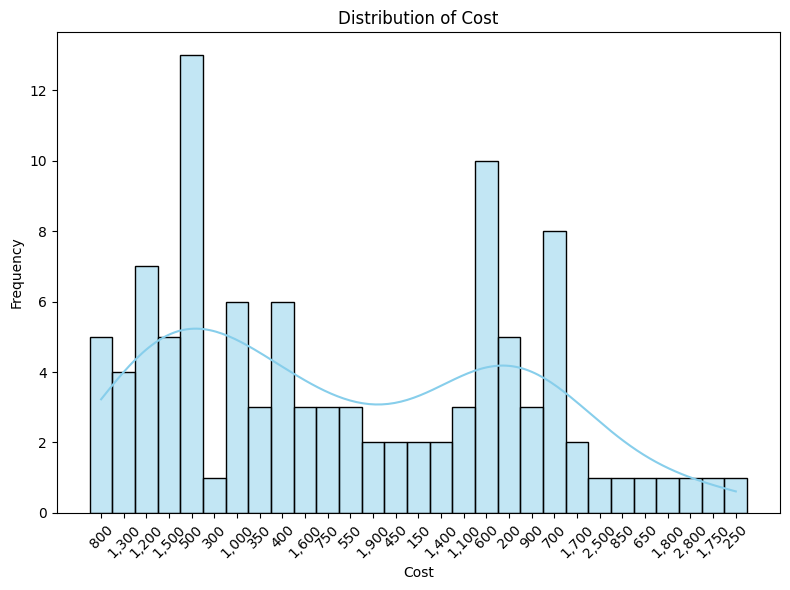

In [23]:
# Visualize the distribution of the 'Cost' feature using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(clustering_df['Cost'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


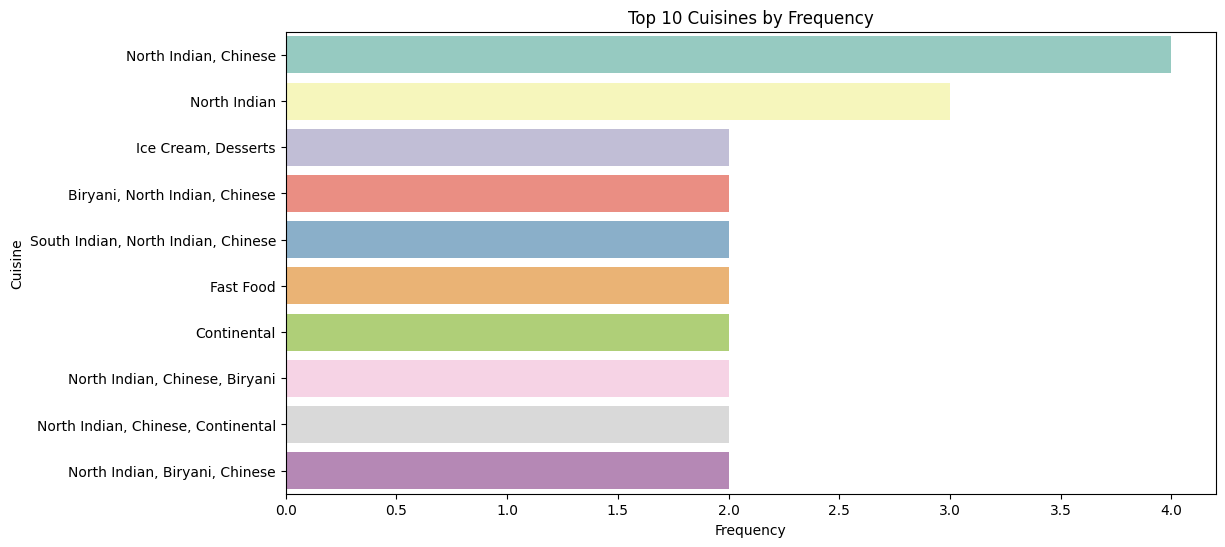

In [24]:
# Aggregate the data by counting the occurrences of each cuisine
cuisine_counts = clustering_df['Cuisines'].value_counts()

# Visualize the distribution of cuisines using a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=clustering_df, y='Cuisines', order=cuisine_counts.index[:10], palette='Set3')
plt.title('Top 10 Cuisines by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Cuisine')
plt.show()


## 2. ***Variables Description***

Zomato Restaurant names and Metadata
Name : Name of Restaurants

Links : URL Links of Restaurants

Cost : Per person estimated Cost of dining

Collection : Tagging of Restaurants w.r.t. Zomato categories

Cuisines : Cuisines served by Restaurants

Timings : Restaurant Timings

Zomato Restaurant reviews
Restaurant : Name of the Restaurant

Reviewer : Name of the Reviewer

Review : Review Text

Rating : Rating Provided by Reviewer

MetaData : Reviewer Metadata - No. of Reviews and followers

Time: Date and Time of Review

Pictures : No. of pictures posted with review

## 3. ***Data Wrangling***

In [25]:
# Convert the 'Cost' column, deleting the comma and changing the data type into 'int64'.

clustering_df['Cost'] =  clustering_df['Cost'].str.replace(",","").astype('int64')

In [26]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    int64 
 3   Collections  105 non-null    object
 4   Cuisines     105 non-null    object
 5   Timings      105 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.0+ KB


In [45]:
# proportion or percentage of occurrences for each unique value in the Rating column.
sentiment_df['Rating'].value_counts(normalize=True)

5    0.384368
4    0.250050
1    0.174302
3    0.119751
2    0.071529
Name: Rating, dtype: float64

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

In [27]:
# Chart - 1 visualization code.

top10_res_by_cost = clustering_df[['Name','Cost']].groupby('Name',as_index=False).sum().sort_values(by='Cost',ascending=False).head(10)

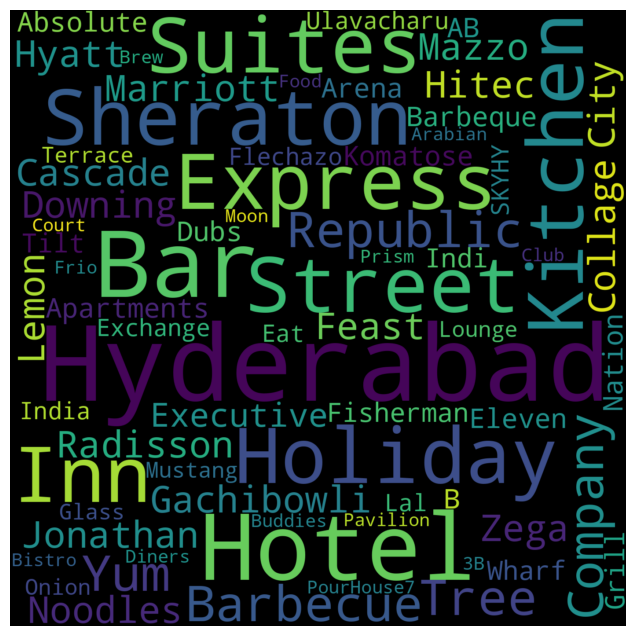

In [28]:
# Creating word cloud for Top expensive restaurants.
plt.figure(figsize=(15,8))
text = " ".join(name for name in clustering_df.sort_values('Cost',ascending=False).Name[:30])

# Creating word_cloud with text as argument in .generate() method.
word_cloud = WordCloud(width = 1400, height = 1400,collocations = False, background_color = 'black').generate(text)

# Display the generated Word Cloud.
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off");

#### Chart - 2

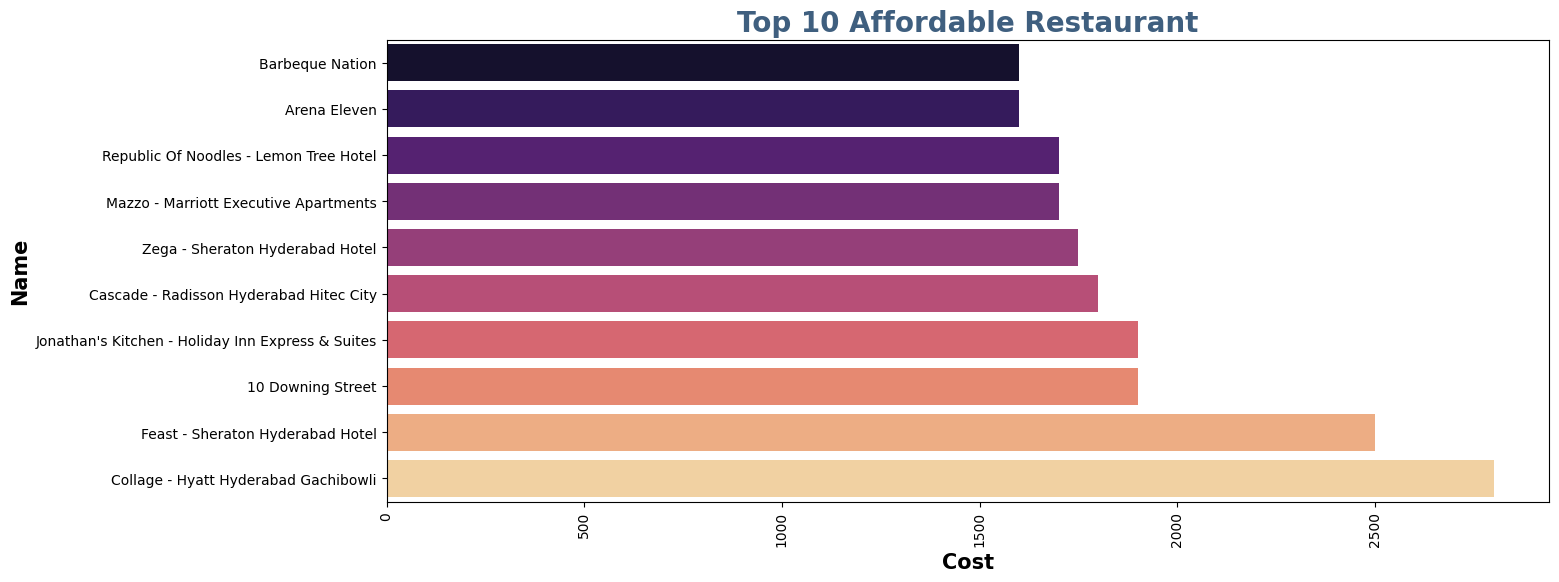

In [29]:
# Affordable price restaurants.

plt.figure(figsize=(15,6))

# Performing groupby To get values accourding to Names and sort it for visualisation.
top_10_affor_rest= clustering_df[['Name','Cost']].groupby('Name',as_index=False).sum().sort_values(by='Cost',ascending=True).tail(10)

# Lables for X and Y axis
x = top_10_affor_rest['Cost']
y = top_10_affor_rest['Name']

# Assigning the arguments for chart
plt.title("Top 10 Affordable Restaurant",fontsize=20, weight='bold',color=sns.cubehelix_palette(8, start=.5, rot=-.75)[-3])
plt.ylabel("Name",weight='bold',fontsize=15)
plt.xlabel("Cost",weight='bold',fontsize=15)
plt.xticks(rotation=90)
sns.barplot(x=x, y=y,palette='magma')
plt.show()


The plot shows the top 10 affordable restaurants based on their total cost. The y-axis represents the restaurant names, while the x-axis shows the total cost. The affordable restaurants are sorted in ascending order of their cost.

#### Chart - 3

<Axes: >

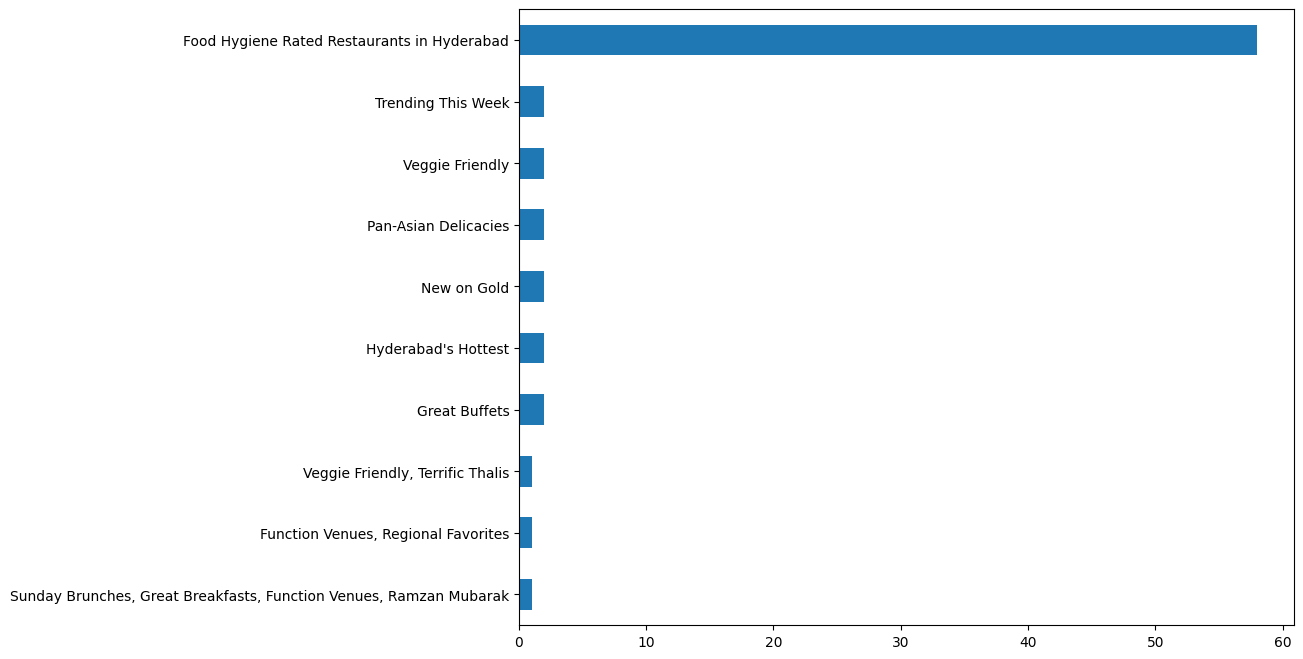

In [30]:
# Visualisation the value counts of collection.
clustering_df['Collections'].value_counts()[0:10].sort_values().plot(figsize=(10,8),kind='barh')


The DataFrame contains two columns: "Cuisine Words" and "Frequency." The "Cuisine Words" column lists the most frequent two-word cuisine terms, while the "Frequency" column shows the number of times each two-word cuisine term appears in the dataset.This information can be helpful in understanding the most common cuisine types in the dataset. It can also be used to identify trends and patterns in the types of cuisines that are popular or in demand among the customers.

## Text preprocessing for the meta dataset.

In Order to plot the cuisines from the data we have to count the frequency of the words from the document.(Frequency of cuisine). For that We have to perform the opration like removing stop words, Convert all the text into lower case, removing punctuations, removing repeated charactors, removing Numbers and emojies and finally count vectorizer.

In [32]:
# Downloading and importing the dependancies for text cleaning.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
# Extracting the stopwords from nltk library for English corpus.
sw = stopwords.words('english')

In [34]:
# Creating a function for removing stopwords.
def stopwords(text):
    '''a function for removing the stopword'''

    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in str(text).split() if word.lower() not in sw]

    # joining the list of words with space separator
    return " ".join(text)

In [35]:
# Removing stopwords from Cuisines.
clustering_df['Cuisines'] = clustering_df['Cuisines'].apply(lambda text: stopwords(text))
clustering_df['Cuisines'].head()

0    chinese, continental, kebab, european, south i...
1                       biryani, north indian, chinese
2         asian, mediterranean, north indian, desserts
3    biryani, north indian, chinese, seafood, bever...
4    asian, continental, north indian, chinese, med...
Name: Cuisines, dtype: object

Stop words are removed successfully

In [36]:
# Defining the function for removing punctuation.
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string

    # replacing the punctuations with no space,
    # which in effect deletes the punctuation marks
    translator = str.maketrans('', '', string.punctuation)

    # return the text stripped of punctuation marks
    return text.translate(translator)

In [37]:
# Removing punctuation from Cuisines.
clustering_df['Cuisines'] = clustering_df['Cuisines'].apply(lambda x: remove_punctuation(x))
clustering_df['Cuisines'].head()

0    chinese continental kebab european south india...
1                         biryani north indian chinese
2            asian mediterranean north indian desserts
3       biryani north indian chinese seafood beverages
4    asian continental north indian chinese mediter...
Name: Cuisines, dtype: object

Punctuations present in the text are removed successfully

In [38]:
# Cleaning and removing Numbers.
import re

# Writing a function to remove repeating characters.
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

In [39]:
# Removing repeating characters from Cuisines.
clustering_df['Cuisines'] = clustering_df['Cuisines'].apply(lambda x: cleaning_repeating_char(x))
clustering_df['Cuisines'].head()

0    chinese continental kebab european south india...
1                         biryani north indian chinese
2            asian mediterranean north indian desserts
3       biryani north indian chinese seafood beverages
4    asian continental north indian chinese mediter...
Name: Cuisines, dtype: object

Removed repeated characters successfully

In [40]:
# Removing the Numbers from the data.
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [41]:
# Implementing the cleaning.
clustering_df['Cuisines'] = clustering_df['Cuisines'].apply(lambda x: cleaning_numbers(x))
clustering_df['Cuisines'].head()

0    chinese continental kebab european south india...
1                         biryani north indian chinese
2            asian mediterranean north indian desserts
3       biryani north indian chinese seafood beverages
4    asian continental north indian chinese mediter...
Name: Cuisines, dtype: object

We dont want numbers in the text Hence removed number successfully

In [42]:
# Top 20 Two word Frequencies of Cuisines.
from collections import Counter
text = ' '.join(clustering_df['Cuisines'])

# separating each word from the sentences
words = text.split()

# Extracting the first word from the number for cuisines in the sentence.
two_words = {' '.join(words):n for words,n in Counter(zip(words, words[1:])).items() if not  words[0][-1]==(',')}

In [43]:
# Extracting the most frequent cuisine present in the collection.
# Counting a frequency for cuisines.
two_words_dfc = pd.DataFrame(two_words.items(), columns=['Cuisine Words', 'Frequency'])

# Sorting the most frequent cuisine at the top and order by descending
two_words_dfc = two_words_dfc.sort_values(by = "Frequency", ascending = False)

# selecting first top 20 frequent cuisine.
two_words_20c = two_words_dfc[:20]
two_words_20c

,Cuisine Words,Frequency
6,north indian,61
9,indian chinese,27
42,fast food,15
4,south indian,9
5,indian north,9
33,chinese north,8
24,indian continental,6
65,italian north,6
8,biryani north,6
28,food north,6


#### Chart - 4

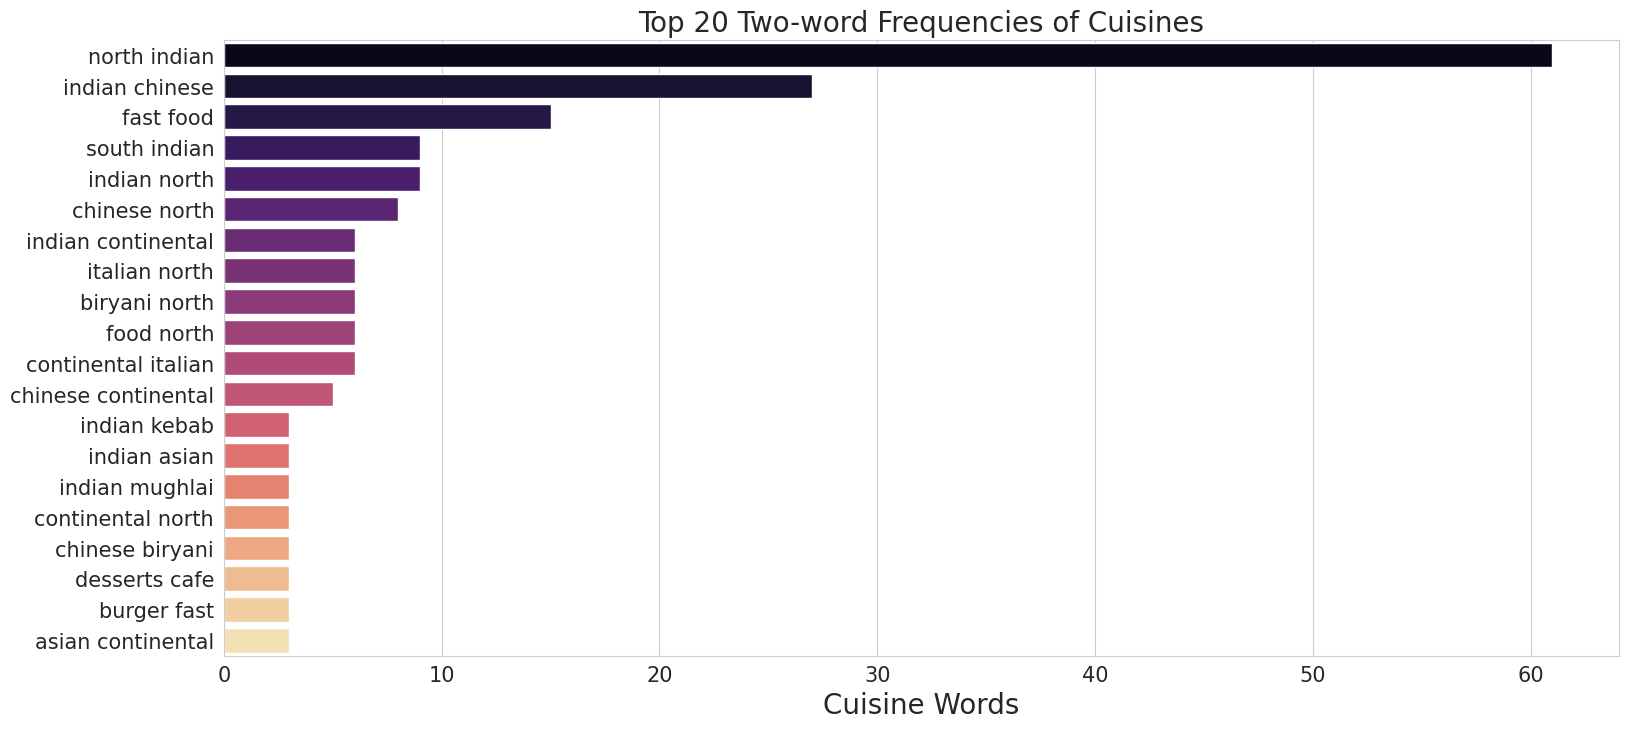

In [44]:
# Visualizing the frequency of the Cuisines.

sns.set_style("whitegrid")
plt.figure(figsize = (18, 8))
sns.barplot(y = "Cuisine Words", x = "Frequency", data = two_words_20c, palette = "magma")
plt.title("Top 20 Two-word Frequencies of Cuisines", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cuisine Words", size = 20)
plt.ylabel(None)
plt.savefig("Top_20_Two-word_Frequencies_of_Cuisines.png")
plt.show()

The DataFrame contains two columns: "Cuisine Words" and "Frequency." The "Cuisine Words" column lists the most frequent two-word cuisine terms, while the "Frequency" column shows the number of times each two-word cuisine term appears in the dataset.This information can be helpful in understanding the most common cuisine types in the dataset. It can also be used to identify trends and patterns in the types of cuisines that are popular or in demand among the customers.

#### Chart - 7

In [46]:
# We will extrapolate the 15 profiles that have made more reviews.

# Groupby on the basis of rivewer gives the fequency of the reviews
reviewer_list = sentiment_df.groupby('Reviewer').apply(lambda x: x['Reviewer'].count()).reset_index(name='Review_Count')

 # Sorting the frequency of reviews decending
reviewer_list = reviewer_list.sort_values(by = 'Review_Count',ascending=False)

# Selecting the top 15 reviewrs
top_reviewers = reviewer_list[:15]


Text(0, 0.5, 'N of reviews')

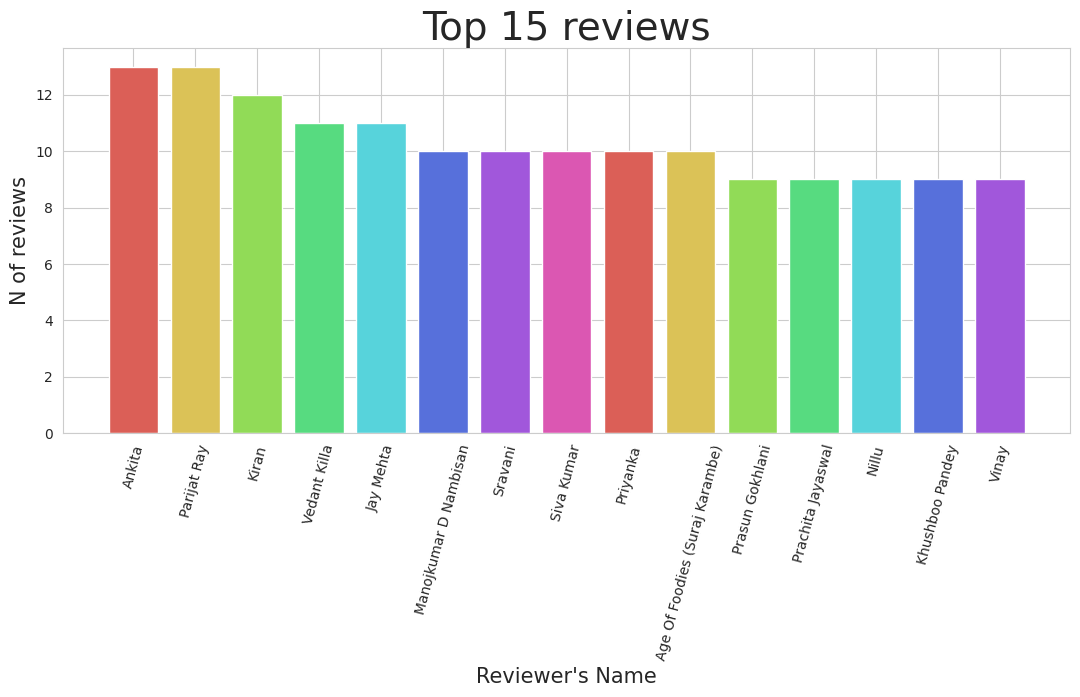

In [47]:
# Visualizing the top 15 reviewers.
plt.figure(figsize=(13,5))
plt.bar(top_reviewers['Reviewer'], top_reviewers['Review_Count'], color = sns.color_palette("hls", 8))
plt.xticks(rotation=75)
plt.title('Top 15 reviews',size=28)
plt.xlabel("Reviewer's Name",size=15)
plt.ylabel('N of reviews',size=15)

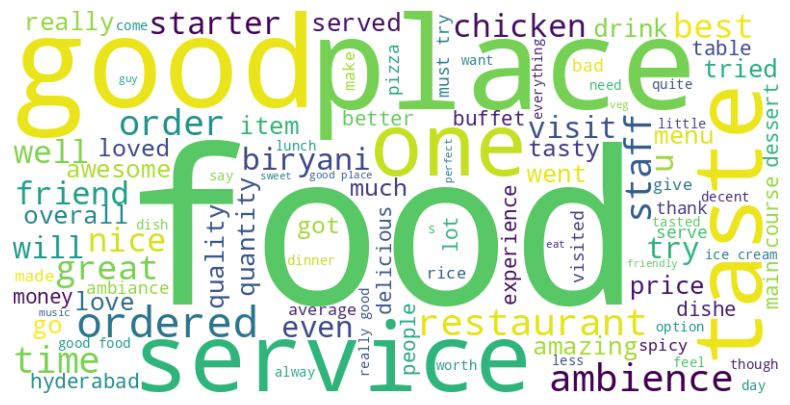

In [49]:
# Word cloud for positive reviews.
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

# Convert 'Review' column to string type
sentiment_df['Review'] = sentiment_df['Review'].astype(str)

# Perform stemming on 'Review' column
ps = PorterStemmer()
sentiment_df['Review'] = sentiment_df['Review'].map(lambda x: ps.stem(x))

# Join all reviews into a long string
long_string = ','.join(list(sentiment_df['Review'].values))

# Generate WordCloud with custom parameters
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue',
                      width=800, height=400)  # Set width and height here
wordcloud.generate(long_string)

# Display the generated WordCloud
plt.figure(figsize=(10, 5))  # Increase figsize for larger display
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Sentiment Analysis


In [50]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.express as px


In [51]:
# Create a function to get the subjectivity
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [52]:
# Create a function to get the polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [54]:
# Applying subjectivity and the polarity function to the respective columns
sentiment_df['Subjectivity'] = sentiment_df['Review'].apply(subjectivity)
sentiment_df['Polarity'] = sentiment_df['Review'].apply(polarity)

In [55]:
# Checking for created columns
sentiment_df['Polarity']


0       0.660000
1       0.606667
2       0.540000
3       0.500000
4       0.577500
          ...   
9995    0.292500
9996    0.186174
9997    0.124535
9998    0.470000
9999    0.079861
Name: Polarity, Length: 9954, dtype: float64

In [56]:
# Checking for created columns
sentiment_df['Subjectivity']

0       0.720000
1       0.613333
2       0.740000
3       0.783333
4       0.570000
          ...   
9995    0.621000
9996    0.724242
9997    0.511157
9998    0.568571
9999    0.588194
Name: Subjectivity, Length: 9954, dtype: float64

In [57]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

If the score is less than 0, the function returns the string 'Negative'. If the score is equal to 0, the function returns the string 'Neutral'. If the score is greater than 0, the function returns the string 'Positive'.

In [58]:
# Apply get analysis function to separate the sentiments from the column
sentiment_df['Analysis'] = sentiment_df['Polarity'].apply(getAnalysis)

In [66]:
import plotly.express as px

# Define custom color mapping for discrete values in the "Analysis" column
color_map = {'positive': 'red', 'negative': 'blue', 'neutral': 'gray'}

fig = px.scatter(sentiment_df,
                 x='Polarity',
                 y='Subjectivity',
                 color='Analysis',
                 size='Subjectivity',
                 color_discrete_map=color_map)  # Use color_discrete_map for custom color mapping



In [67]:
# Add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1,
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

The resulting plot can provide several insights into the sentiment analysis results. Firstly, the histogram bars on the left side of the plot (negative polarity) indicate that a significant number of reviews expressed negative sentiments. Similarly, the histogram bars on the right side of the plot (positive polarity) indicate that a significant number of reviews expressed positive sentiments.

Overall, this plot can provide a quick and easy way to visualize the sentiment polarity distribution of the reviews, which can help in understanding the overall sentiment of the customers towards the restaurants.

# Clustering

In [69]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning);

In [74]:
# converting the cuisines to lower case

clustering_df['Cuisines'] = clustering_df['Cuisines'].apply(lambda x : x.lower());

In [75]:
# Separating the Name, cost and cuisines column.
cuisine_df = clustering_df.loc[:,['Name','Cost','Cuisines']]

In [ ]:
# Overview of separated variables.
cuisine_df.head()

,Name,Cost,Cuisines
0,Beyond Flavours,800,"chinese, continental, kebab, european, south i..."
1,Paradise,800,"biryani, north indian, chinese"
2,Flechazo,"1,300","asian, mediterranean, north indian, desserts"
3,Shah Ghouse Hotel & Restaurant,800,"biryani, north indian, chinese, seafood, bever..."
4,Over The Moon Brew Company,"1,200","asian, continental, north indian, chinese, med..."


In [76]:
# Removing spces from cuisine column.
cuisine_df['Cuisines'] = cuisine_df['Cuisines'].str.replace(' ','')

# Spliting the Words in cuisine.
cuisine_df['Cuisines'] = cuisine_df['Cuisines'].str.split(',')

In [77]:
# Overview on text cleaning.
cuisine_df.head()

,Name,Cost,Cuisines
0,Beyond Flavours,800,[chinesecontinentalkebabeuropeansouthindiannor...
1,Paradise,800,[biryaninorthindianchinese]
2,Flechazo,1300,[asianmediterraneannorthindiandesserts]
3,Shah Ghouse Hotel & Restaurant,800,[biryaninorthindianchineseseafoodbeverages]
4,Over The Moon Brew Company,1200,[asiancontinentalnorthindianchinesemediterranean]


In [78]:
from sklearn.preprocessing import MultiLabelBinarizer

# converting a list of labels for each sample into a binary indicator matrix
mlb = MultiLabelBinarizer(sparse_output=True)

In [79]:
# converting the Cuisines column in the cuisine_df DataFrame into a binary indicator matrix.
cuisine_df = cuisine_df.join(pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(cuisine_df.pop('Cuisines')),
                                                               index=cuisine_df.index, columns=mlb.classes_))

In [80]:
# Overview
cuisine_df.head()

,Name,Cost,american,americanchinesenorthindiankebabsouthindian,americanfastfoodsaladburger,americanwrapsdesserts,andhrabiryanihyderabadinorthindian,andhranorthindianchinese,andhrasouthindiannorthindian,arabiannorthindianchinese,...,northindianjapaneseitaliansaladsushi,northindianmediterraneaneuropean,northindianmughlai,northindianmughlaibeverages,northindiansouthindian,seafoodgoannorthindiancontinentalasian,southindiannorthindianchinese,streetfoodarabian,streetfoodnorthindianfastfood,thaiasianchinesemalaysian
0,Beyond Flavours,800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Paradise,800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Flechazo,1300,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Shah Ghouse Hotel & Restaurant,800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Over The Moon Brew Company,1200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# Checking the unique for rating.
sentiment_df['Rating'].unique()

array([5, 4, 1, 3, 2])

In [83]:
# Remove nan rating in Rating column.
sentiment_df.dropna(subset=['Rating'],inplace=True)

In [84]:
# Change data type of rating column to float.
sentiment_df['Rating']= sentiment_df['Rating'].astype('float')

In [85]:
# Dropping the null Values from review column.
sentiment_df.dropna(subset =['Review'], inplace=True)

In [86]:
# Grouping the restaurant on the basis of average rating.
ratings_df = sentiment_df.groupby('Restaurant')['Rating'].mean().reset_index()

In [87]:
# Top highly rated 15 restaurants.
ratings_df .sort_values(by='Rating',ascending = False).head(15)

,Restaurant,Rating
3,AB's - Absolute Barbecues,4.880000
11,B-Dubs,4.810000
2,"3B's - Buddies, Bar & Barbecue",4.760000
67,Paradise,4.700000
35,Flechazo,4.660000
87,The Indi Grill,4.600000
97,Zega - Sheraton Hyderabad Hotel,4.450000
64,Over The Moon Brew Company,4.340000
16,Beyond Flavours,4.280000
19,Cascade - Radisson Hyderabad Hitec City,4.260000


In [88]:
#  Combining the information on restaurant cuisine and ratings into a single DataFrame.
df_cluster = cuisine_df.merge(ratings_df, left_on='Name',right_on='Restaurant')

In [89]:
# Overview
df_cluster.head()

,Name,Cost,american,americanchinesenorthindiankebabsouthindian,americanfastfoodsaladburger,americanwrapsdesserts,andhrabiryanihyderabadinorthindian,andhranorthindianchinese,andhrasouthindiannorthindian,arabiannorthindianchinese,...,northindianmughlai,northindianmughlaibeverages,northindiansouthindian,seafoodgoannorthindiancontinentalasian,southindiannorthindianchinese,streetfoodarabian,streetfoodnorthindianfastfood,thaiasianchinesemalaysian,Restaurant,Rating
0,Beyond Flavours,800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Beyond Flavours,4.28
1,Paradise,800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Paradise,4.70
2,Flechazo,1300,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Flechazo,4.66
3,Shah Ghouse Hotel & Restaurant,800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Shah Ghouse Hotel & Restaurant,3.21
4,Over The Moon Brew Company,1200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Over The Moon Brew Company,4.34


In [ ]:
# Changing name and order of columns
df_cluster = df_cluster[['Name', 'Cost','Rating', 'american', 'andhra', 'arabian', 'asian', 'bbq',
       'bakery', 'beverages', 'biryani', 'burger', 'cafe', 'chinese',
       'continental', 'desserts', 'european', 'fastfood', 'fingerfood', 'goan',
       'healthyfood', 'hyderabadi', 'icecream', 'indonesian', 'italian',
       'japanese', 'juices', 'kebab', 'lebanese', 'malaysian', 'mediterranean',
       'mexican', 'mithai', 'modernindian', 'momos', 'mughlai', 'northeastern',
       'northindian', 'pizza', 'salad', 'seafood', 'southindian', 'spanish',
       'streetfood', 'sushi', 'thai', 'wraps']]


In [90]:
# Checking the data type and null counts for newly created variables.
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 96 columns):
 #   Column                                                 Non-Null Count  Dtype           
---  ------                                                 --------------  -----           
 0   Name                                                   100 non-null    object          
 1   Cost                                                   100 non-null    int64           
 2   american                                               100 non-null    Sparse[int64, 0]
 3   americanchinesenorthindiankebabsouthindian             100 non-null    Sparse[int64, 0]
 4   americanfastfoodsaladburger                            100 non-null    Sparse[int64, 0]
 5   americanwrapsdesserts                                  100 non-null    Sparse[int64, 0]
 6   andhrabiryanihyderabadinorthindian                     100 non-null    Sparse[int64, 0]
 7   andhranorthindianchinese                              

In [92]:
# Changing the data type of the cost column.
df_cluster['Cost']= df_cluster['Cost'].astype('float')

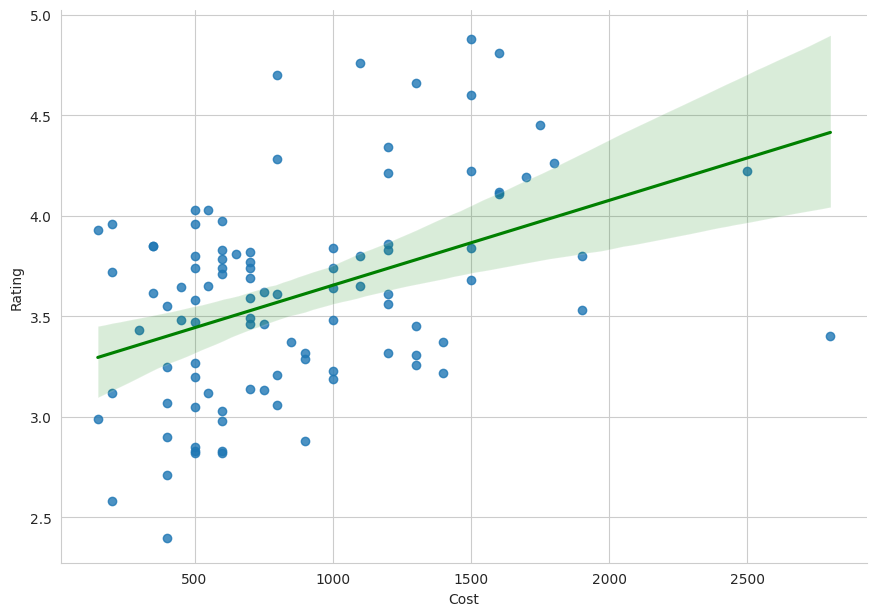

In [95]:
# Visualising relationship between the cost of a meal and the rating of a restaurant

sns.lmplot(y='Rating', x='Cost', data=df_cluster, line_kws={'color': 'Green'}, height=6.27, aspect=11.7/8.27)


The resulting plot shows the relationship between the cost of a meal and the rating of a restaurant, with the regression line indicating the general trend in the data. This can help identify any patterns or correlations between cost and rating.

# **Conclusion**


The project accomplished its objectives in both clustering and sentiment analysis. Through clustering, valuable insights were gained regarding the categorization of restaurants based on their attributes, offering potential guidance for both users and businesses in decision-making processes. The sentiment analysis segment yielded valuable insights into user sentiments expressed in reviews, offering businesses opportunities for enhancing their services and overall user experience.

Moving forward, there are numerous avenues for further exploration. These include the implementation of more sophisticated clustering algorithms and sentiment analysis methodologies, the integration of additional features like restaurant images and menus, and investigating potential correlations between clustering outcomes and sentiment analysis results. These avenues hold promise for enhancing the depth and breadth of insights gleaned from the data.